![](pics/header.jpg)

# IMU Calibration

Kevin J. Walchko

10 July 2022

---

## Sensor

[![](pics/imu.jpg)](https://www.adafruit.com/product/4517)

- **LSM6DSOX**:
    - Accelerometer ±2/±4/±8/±16 g at 1.6 Hz to 6.7KHz update rate
    - Gyroscope: ±125/±250/±500/±1000/±2000 dps at 12.5 Hz to 6.7 KHz
    - Continuous and single-conversion modes
    - Advanced pedometer, step detector and step counter
    - Significant Motion Detection, Tilt detection
    - Standard interrupts: free-fall, wakeup, 6D/4D orientation, click and double-click
    - Programmable finite state machine: accelerometer, gyroscope and external sensors
    - Machine Learning Core
    - I2C Address `0x6A` or `0x6B`
- **LIS3MDL**:
    - ±4/±8/±12/±16 gauss selectable magnetic full scales
    - Continuous and single-conversion modes
    - 16-bit data output
    - Interrupt generator
    - I2C Address `0x1C` or `0x1E`

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [1]:
from collections import deque
from matplotlib import pyplot as plt
import numpy as np
from ins_nav.storage import from_pickle

In [2]:
def plot3(x,y,title=None):
    plt.plot(x,y[:,0],label="x")
    plt.plot(x,y[:,1],label="y")
    plt.plot(x,y[:,2],label="z")
    plt.grid(True)
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.xlabel("Time [sec]");

In [4]:
datainfo = from_pickle("data-2022-07-10.pkl")

numberPoints = datainfo["count"]
data = np.array(datainfo["data"])
axisOrder = datainfo["order"]

print(">> Semsor info:")
print(datainfo["info"])

data = np.array(data)
print(f">> Sensor data has {data.shape} points")

>> Loaded data from data-2022-07-10.pkl
>> Semsor info:
{'LSM6DSOX': {'accel': ('4000G', '208Hz'), 'gyro': ('2000DPS', '208Hz'), 'temp': 'Celcius'}, 'LIS3MDL': {'mag': ('4GAUSS', '300Hz')}}
>> Sensor data has (6000, 11) points


In [5]:
accel = data[:,0:3]
gyro = data[:,3:6]
mag = data[:,6:9]
temp = data[:,9]
ts = (data[:,10] - data[0,10])*1e-6
hz = 1/np.diff(data[:,10])*1e6

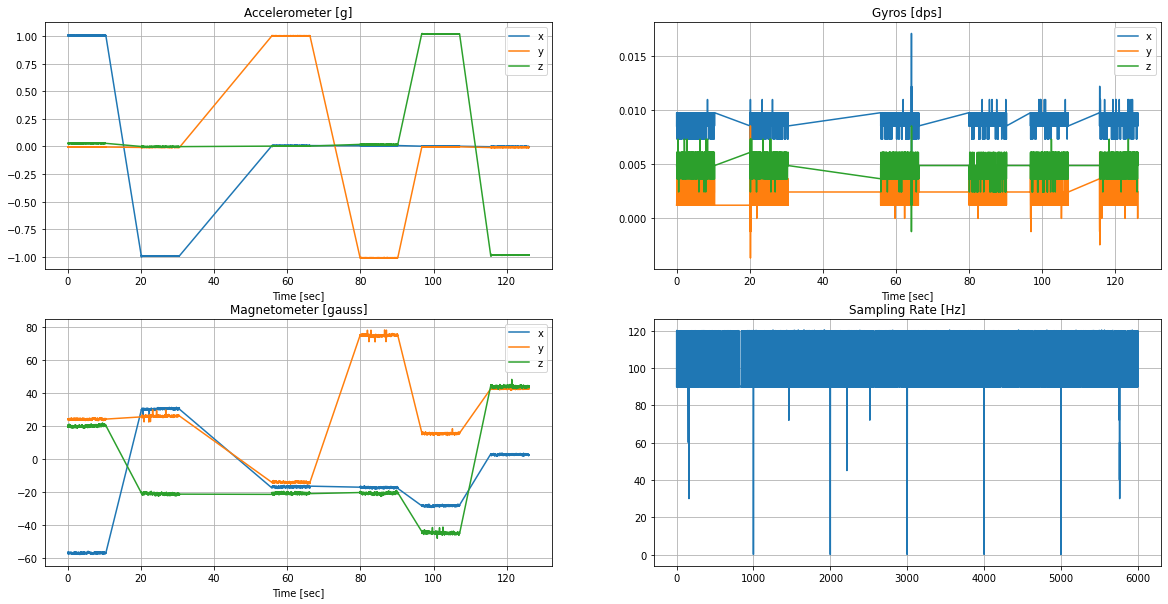

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plot3(ts, accel, "Accelerometer [g]")
plt.subplot(2,2,2)
plot3(ts, gyro, "Gyros [dps]")
plt.subplot(2,2,3)
plot3(ts, mag, "Magnetometer [gauss]")
plt.subplot(2,2,4)
plt.plot(hz)
plt.grid(True)
plt.title("Sampling Rate [Hz]");

## Accelerometer Calibration



Although accelerometers come from the factory calibrated to a rough level for drop detection or car impact detection, this calibration is not sufficient for inerital navigation. Here we are going to follow the AN4508 application note on how to calibrate an accelerometer using least squares.

Following Table 1, we are going to collect measurements in the following 6 orienations:

- x up/down
- y up/down
- z up/down

Then rely on least squares ($Ax=B$) to calculate the misalignments and offsets to recover the *true* measurements. `numpy.linalg.lstsq()` return the least-squares solution to a linear matrix equation.Solves the equation a x = b by computing a vector x that minimizes the Euclidean L2-norm ($|| b – a x ||^2$). 

## References

- AN4508: [Parameters and calibration of a low-g 3-axis accelerometer](AN4508.pdf)
- Vectornav: [Accelerometer](https://www.vectornav.com/support/library/accelerometer)
- [Least squares fitting with Numpy and Scipy](https://mmas.github.io/least-squares-fitting-numpy-scipy)
- GeeksforGeeks: [Numpy Linear Algebra](https://www.geeksforgeeks.org/numpy-linear-algebra/)
- Wikipedia: [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance)
- Oxford Reference: [International Gravity Formula](https://www.oxfordreference.com/view/10.1093/oi/authority.20110803100007626)

## Accelerometer Model

We can view the sensor model as a the transformation of the *true* acceleration measurement ($\vec{a}$) morphed into a noisy measurement ($\vec{am}$) due to misalignments, biases (offsets), etc. Mathematically it is:

$$
\begin{align*}
\vec{a} &= \mathbf{M} \mathbf{S} (\vec{am} - \vec{b}) \\
\begin{bmatrix}
a_x \\ a_y \\ a_z
\end{bmatrix} &= 
\begin{bmatrix}
1 & M_{xy} & M_{xz} \\
M_{yx} & 1 & M_{yz} \\
M_{zx} & M_{zy} & 1
\end{bmatrix}
\begin{bmatrix}
\frac{1}{S_x} & 0 & 0\\
0 & \frac{1}{S_y} & 0\\
0 & 0 & \frac{1}{S_z}
\end{bmatrix}
\begin{bmatrix}
am_x - b_x \\ am_y - b_y \\ am_z - b_z
\end{bmatrix} 
\end{align*}
$$

where $\mathbf{M}$ is cross coupling due to non-orthogonal sensor axes created during senors construction, $\mathbf{S}$ is sensitivity errors, and $\vec{b}$ are constant bias offsets. Now we can solve and get the *true* acceleration, but then we are going to put it into a form for least squares that looks like $Ax=B$. First we need to do a little rearranging:

$$
\begin{align*}
\vec{a} &= \mathbf{M} \mathbf{S} \vec{am} + \mathbf{M} \mathbf{S} \vec{b} \\
\vec{a} &= [\mathbf{M} \mathbf{S} | \vec{b}]_{3x4}
\begin{bmatrix}
am_x & am_y & am_z & 1
\end{bmatrix}^T \\
\vec{a} &=[\vec{am} | 1] [\mathbf{M} \mathbf{S} | \vec{b}]^T_{4x3}\\
B &= A_{1x4} [x]_{4x3}
\end{align*}
$$

where $[\mathbf{M} \mathbf{S} | \vec{b}]^T_{4x3}$ is a constant matrix of correction coefficients. Now, for least squares, $A$ becomes our noisy measurements and $B$ is our ideal states. In order to clean up our noisy measurements, we just post-multiply by our $x$ matrix (which least squares finds). So for $n$ samples, our solution becomes:

$$
\begin{align*}
\vec{a}_{nx3} &= [\vec{am} | 1]_{nx4} [\mathbf{M} \mathbf{S} | \vec{b}]^T_{4x3}\\
B &= A_{nx4} [x]_{4x3}
\end{align*}
$$

where $B$ is $\begin{bmatrix} 0 & 0 & g \end{bmatrix}^T_{nx3}$ for z-axis up and $\begin{bmatrix} 0 & 0 & -g \end{bmatrix}^T_{nx3}$ for z-axis down. 

In [8]:
from ins_nav.calibration import accelcal
from ins_nav.calibration.calaccel import correct

In [10]:
xx = accelcal(accel,axisOrder)

Rank: 4
Singular values: [77.47361631 45.04452898 44.90649329 44.28032524]
Sum residual error: 0.1264191762510688
--------------------------------
[[ 1.00268927e+00 -1.38897820e-03 -1.43827092e-02]
 [-5.60288252e-04  9.95808182e-01  6.73172084e-03]
 [-1.90925159e-03 -2.27335294e-03  9.99895405e-01]
 [-4.92348154e-03  5.03834722e-03 -1.36475905e-02]]


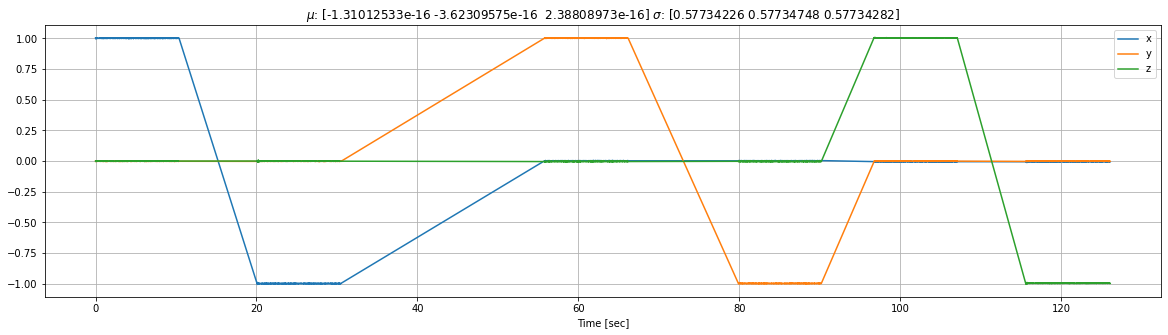

In [11]:
caccel = correct(accel, xx)
plt.figure(figsize=(20,5))
plot3(ts, caccel,f"$\mu$: {np.mean(caccel, axis=0)} $\sigma$: {np.std(caccel, axis=0)}")

# Gyroscope Calibration

The gyros will follow a simpler method. Basically, when all of this data was taken, the IMU was stationary, hence, all values should be zero. So we are going to find the best bias values to compensate.

Ideally, we would spin the gyros around all 6 orientations at a known speed and gather data to use in a least squared solution. Unfortunatly, I do not have the equipment to test that way.

In [12]:
xxx = np.vstack((np.eye(3),-np.mean(gyro, axis=0)))
print(xxx)

[[ 1.          0.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          0.          1.        ]
 [-0.00889949 -0.00235061 -0.00475294]]


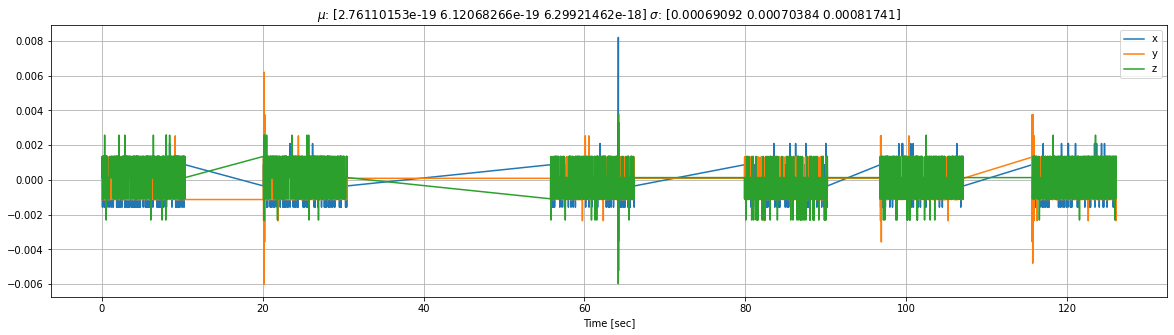

In [13]:
cgyro = correct(gyro, xxx)
plt.figure(figsize=(20,5))
plot3(ts, cgyro,f"$\mu$: {np.mean(cgyro, axis=0)} $\sigma$: {np.std(cgyro, axis=0)}")

## Magnetometer Calibration

To calibrate a magnetometer, you need to get readings from all directions in 3D space. Ideally, when you plot the readings out, you should get a perfect sphere centered at (0,0,0). However, due to misalignments, offset, etc ... you end up with ellipsoids centered at some biased location.

Here we are going to try and get enough readings to estimate these errors and properly calibrate the sensor. We will load in a pre-recorded data set, where the sensor was tumbled around and calibrate it.

## Errors

![](pics/soft-and-hard.png)

- **Soft iron errors:** caused by distortion of the Earth's magnetic field due to materials in the environment. Think of it like electricity - the magnetic field is looking for the easiest path to get to where it is going. Since magnetic fields can flow more easily through ferromagnetic materials than air, more of the field will flow through the ferromagnetic material than you would expect if it were just air. This distortion effect causes the magnetic field lines to be bent sometimes quite a bit. Note that unlike hard iron interference which is the result of materials which actually have a magnetic field of their own, soft iron interference is caused by non-magnetic materials distorting the Earth's magnetic field. This type of interference has a squishing effect on the magnetic data circle turning it into more of an ellipsoid shape. The distortion in this case depends on the direction that the compass is facing. Because of this, the distortion cannot be calibrated out with a simple offset
- **Hard iron errors:** caused by static magnetic fields associated with the enviornment. For example, this could include any minor (or major) magnetism in the metal chassis or frame of a vehicle, any actual magnets such as speakers, etc... This interference pattern is unique to the environment but is constant. If you have your compass in an enclosure that is held together with metal screws, these relatively small amounts of ferromagnetic material can cause issues. If we consider the magnetic data circle, hard iron interference has the effect of shifting the entire circle away from the origin by some amount. The amount is dependent on any number of different factors and can be very large. 

## Calibrations

In all cases, you need to gather data from the magnitometers across
all axes. The best way is to tumble it and grave a couple thousand
data points.


## References

- Ozyagcilar, T. ["Calibrating an eCompass in the Presence of Hard and Soft-iron Interference."](AN4246.pdf) Freescale Semiconductor Ltd. 1992, pp. 1-17.
- [Teslabs: Magnetometer Calibration](https://teslabs.com/articles/magnetometer-calibration/)
- [ThePoorEngineer: Calibrating the Magnetometer](https://www.thepoorengineer.com/en/calibrating-the-magnetometer/)
- Mathworks: [magcal](https://www.mathworks.com/help/fusion/ref/magcal.html#mw_34252c54-1f78-46b9-8c30-1a2b7351b0ce)

In [15]:
from ins_nav.calibration import magcal
from ins_nav.calibration import magplot

In [16]:
!ls -alh *.pkl

-rw-r--r--  1 kevin  staff   586K Jul 10 08:32 data-2022-07-10.pkl
-rw-r--r--  1 kevin  staff    49K Jul 10 10:01 data-mag-2022-07-10.pkl


In [17]:
datainfo = from_pickle("data-mag-2022-07-10.pkl")
mag = np.array(datainfo["data"])[:,6:9]
print(f">> Found {len(mag)} points")

>> Loaded data from data-mag-2022-07-10.pkl
>> Found 513 points


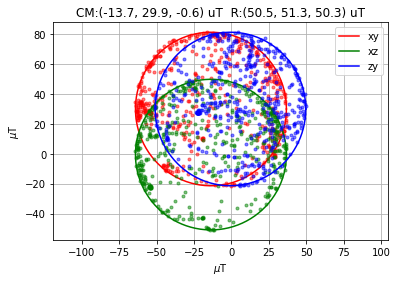

In [18]:
magplot(mag)

In [20]:
# https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm
# uT
uT = 48.7102

# Matlab `magcal`

`A, b, expfs = magcal(D, [uT])`

$$
C = (D-b)A
$$

where $C$ is the corrected reading, $D$ is the raw magnetometer reading, $b$ is the hard iron effect (bias), and $A$ is the soft iron effect (shape). 

- matlab: [magcal](https://www.mathworks.com/help/nav/ref/magcal.html)

>> soft-iron correction:
[[0.96545537 0.         0.        ]
 [0.         0.94936676 0.        ]
 [0.         0.         0.967698  ]]
>> hard-iron offset: [-13.15340002  29.7714855    0.0645215 ] uT
>> expected magnetic field (expmfs): 50.2 uT


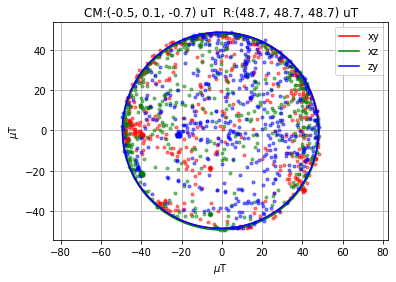

In [21]:
A,b,expmfs = magcal(mag,uT)
print(f">> soft-iron correction:\n{A}")
print(f">> hard-iron offset: {b} uT")
print(f">> expected magnetic field (expmfs): {expmfs:.1f} uT")
magplot((mag-b).dot(A))

# Appendix: `accelcal`

In [23]:
from jtb import getCode

getCode(imp=accelcal)

# Appendix: `magcal`

In [24]:
getCode(imp=magcal)